In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from torch.autograd import Variable
from PIL import Image
from glob import glob
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
train_files = glob('./mnist/mnist/train/*/*.png')
valid_files = glob('./mnist/mnist/valid/*/*.png')
test_files = glob('./mnist/mnist/test/*/*.png')

In [3]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

# Primer punto 

Generamos datos de forma cruzada, sin cruzar. Se va a generar una separación de la información de entreno únicamente usando la función train_test_split de sklearn. Luego se comparan los valores de loss, f1_score y accuracy para cada proporción (0.1,0.2,0.5,0.8 y 1)

In [4]:
N_train = len(train_files)
X_train = []
Y_train = []
for i, train_file in enumerate(train_files):
    Y_train.append( int(train_file.split('\\')[1]) )
    X_train.append(np.array(Image.open(train_file)))
    
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append( int(valid_file.split('\\')[1]) )
    X_valid.append( np.array(Image.open(valid_file)) )
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append( int(test_file.split('\\')[1]) )
    X_test.append( np.array(Image.open(test_file)) )

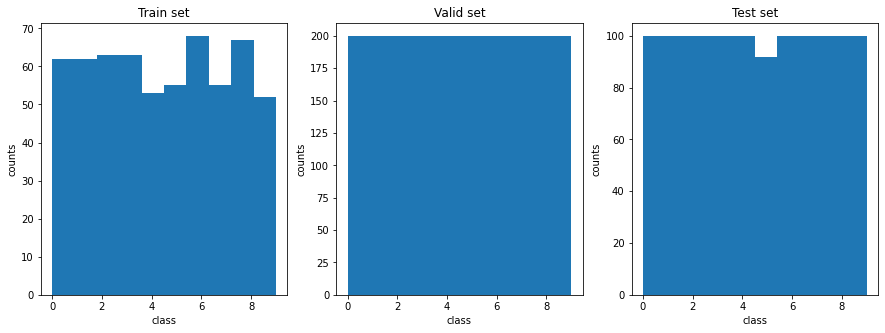

In [5]:
#### Usamos el train_test_split y verifiamos que los datos estén balanceados
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, Y_train,train_size=0.1)
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(y_train1))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

### Verificación de homogeneidad 
Vemos que usando el train_test_split conseguimos una división de clase aleatoria y casi balanceada. Para lo siguiente correremos el código para cada una de las divisiones de información, por lo cual, generaremos listas que contengan los valores de loss, f1_score y accuracy para cada uno de los parametros distintos, es decir, guardaremos listas dentro de listas. Finalmente, graficaremos los valores para cada una de las divisiones de información

In [6]:
f1_glob_train = []
loss_glob_train = []
acc_glob_train = []

f1_glob_valid = []
loss_glob_valid = []
acc_glob_valid = []
input_dim = 28*28
out_dim = 10
hidden = 50

for i in [0.1,0.2,0.5,0.8,0.99999]:
    model = torch.nn.Sequential(
    torch.nn.Linear(input_dim,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,out_dim))
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()

    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_train, Y_train,train_size=i)
    X_train_m = Variable(torch.from_numpy(np.array(X_train_m))).float()
    Y_train_m = Variable(torch.from_numpy(np.array(y_train_m))).long()

    X_valid_m = Variable(torch.from_numpy(np.array(X_valid))).float()
    Y_valid_m = Variable(torch.from_numpy(np.array(Y_valid))).long()
    
    
    n_epochs = 250


    loss_train = []
    f1_train = []
    acc_train = []


    loss_valid = []
    f1_valid = []
    acc_valid = []


    for epoch in range(n_epochs):
        model.train()

        Xtr = X_train_m.view(X_train_m.size(0), -1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train_m)
        loss_train.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_train.append( f1_score(Y_train_m,Y_pred, average='macro') )

        acc = accuracy_score(Y_train_m, Y_pred)
        acc_train.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        Xvl = X_valid_m.view(X_valid_m.size(0), -1)
        Y_pred = model(Xvl)  
        loss = criterion(Y_pred,Y_valid_m)
        loss_valid.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_valid.append( f1_score(Y_valid_m, Y_pred, average='macro') )

        acc = accuracy_score(Y_valid_m, Y_pred)
        acc_valid.append(acc)
    f1_glob_train.append(f1_train)
    acc_glob_train.append(acc_train)
    loss_glob_train.append(loss_train)
    f1_glob_valid.append(f1_valid)
    acc_glob_valid.append(acc_valid)
    loss_glob_valid.append(loss_valid)

Usando el 10.0% de la data de entreno



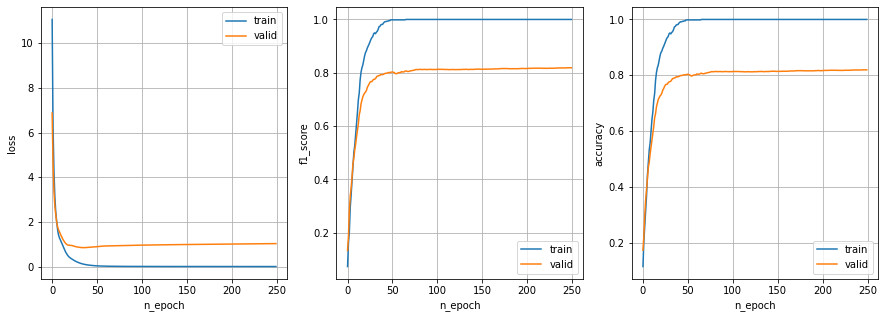

Usando el 20.0% de la data de entreno



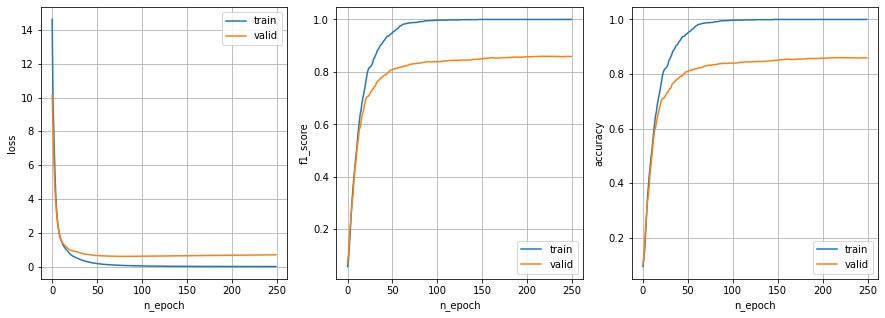

Usando el 50.0% de la data de entreno



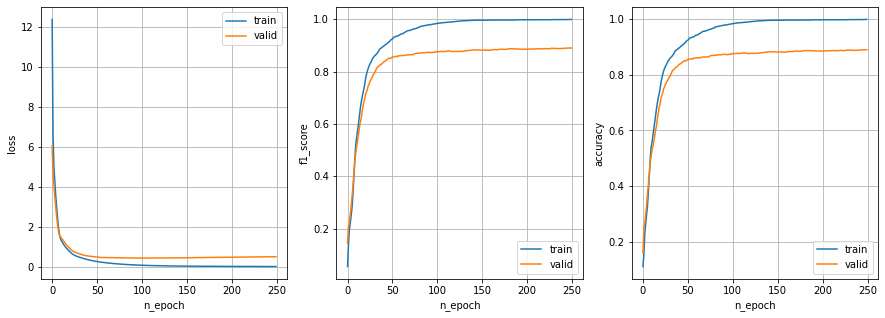

Usando el 80.0% de la data de entreno



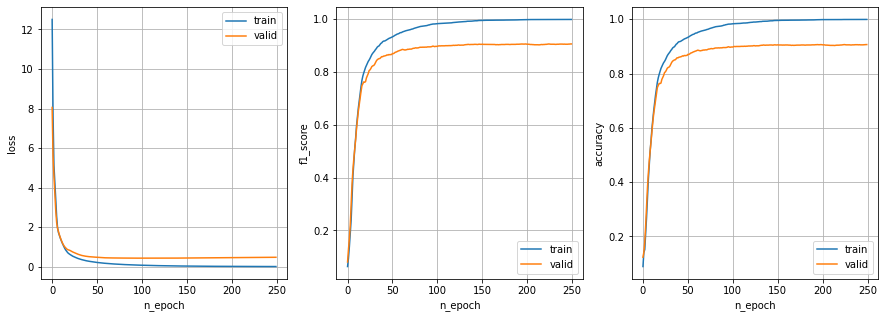

Usando el 99.999% de la data de entreno



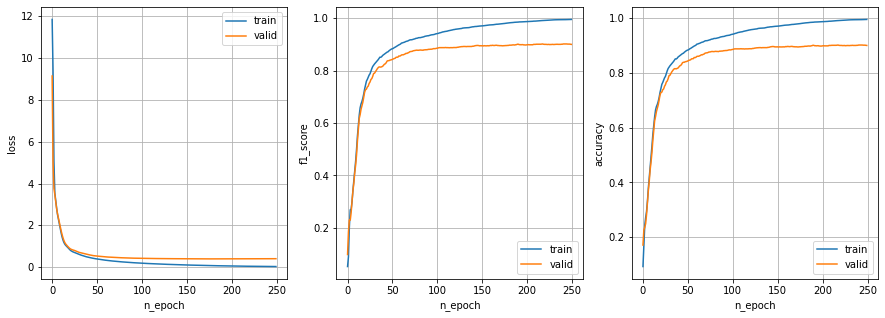

In [7]:
div = [0.1,0.2,0.5,0.8,0.99999]
for i in range(len(div)):
    print('Usando el '+str(round(div[i]*100,3))+'% de la data de entreno' +'\n')
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(range(n_epochs), loss_glob_train[i], label='train')
    plt.plot(range(n_epochs), loss_glob_valid[i], label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.subplot(1,3,2)
    plt.plot(range(n_epochs), f1_glob_train[i], label='train')
    plt.plot(range(n_epochs), f1_glob_valid[i], label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('f1_score')
    plt.legend()
    plt.grid()
    plt.subplot(1,3,3)
    plt.plot(range(n_epochs), acc_glob_train[i], label='train')
    plt.plot(range(n_epochs), acc_glob_valid[i], label='valid')
    plt.xlabel('n_epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    plt.show()

### Análisis de resultados 

Para poder usar el train_test_split, el valor de 1 genera error, por lo cual usamos el valor de 0.99999 que corresponde al 99.999\% de la información. Así, estaremos usando 5999 imagenes en vez de 6000, notando que esto no genera una diferencia notable.
Vemos que claramente el efecto del tamaño del conjunto de entrenamiento es que aumenta la perdida, reduce el valor del f1-score y del accuracy. Esto se evidencia primordialmente en la diferencia de las curvas de validación y entreno para cada una de los tamaños del conjunto de entrenamiento. En los valores de 10\%, 20\% se ve claramente una diferencia grande entre las gráficas, lo que implica que el modelo no se está entrenando correctamente. Sin embargo, al aumentar la cantidad de data de entreno, las dos curvas son más similares, evidenciando que se reduce el error al entrenar el modelo con una proporción alta del conjunto de entreno. 

# Segundo punto 

Para ester punto no es necesario entrenar los modelos en las proporciones mencionadas, sino únicamente entrenar el modelo una vez pero evaluar con los datos de testeo cambiando su proporción. Para esto usaremos nuevamente el train_test_split. Luego, evaluaremos las métricas de pérdida, f1_score y accuracy para las distintas divisiones de la información. En este caso no se generará una gráfica por épocas, sino que se entrenara el modelo una vez y se calcularán 5 valores de las métricas para cada grupo de testeo.

In [8]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 250
for epoch in range(n_epochs):
    model.train()
    Xtr = X_train.view(X_train.size(0),-1)
    Y_pred = model(Xtr)
    loss = criterion(Y_pred,Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
loss_test = []
f1_test = []
acc_test = []
for i in [0.1,0.2,0.5,0.8,0.99999]:
    X_test_m, X_train_m, y_test_m, y_train_m = train_test_split(X_test, Y_test,train_size=i)
    Xtr = X_test_m.view(X_test_m.size(0), -1)
    Y_pred = model(Xtr)
    loss = criterion(Y_pred,y_test_m)
    loss_test.append(loss.item())
    Y_pred = torch.argmax(Y_pred, 1)
    f1_test.append( f1_score(y_test_m,Y_pred, average='macro') )

    acc = accuracy_score(y_test_m, Y_pred)
    acc_test.append(acc)

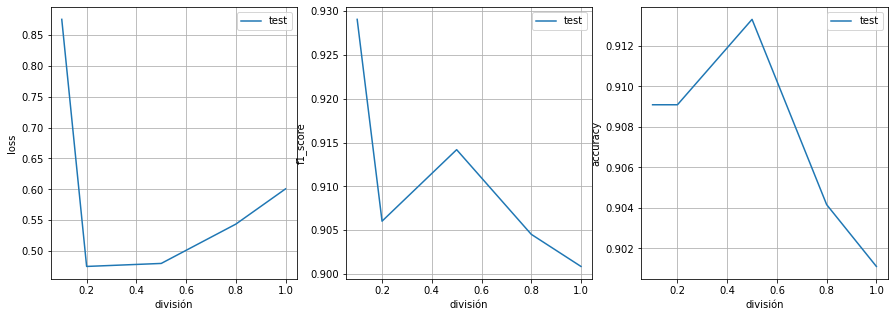

In [9]:
div = [0.1,0.2,0.5,0.8,0.99999]
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(div, loss_test, label='test')
plt.xlabel('división')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(div, f1_test, label='test')
plt.xlabel('división')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(div, acc_test, label='test')
plt.xlabel('división')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

# Conclusiones 

De las gráficas obtenemos un comportamiento extraño. Primero, tenemos que aumentar el tamaño de la data de testeo aumenta la pérdida, lo cual parece ser incoherente. Sin embargo, para los valores de f1_score y accuracy tenemos que cambiar el tamaño de la data de testeo varía de forma muy pequeña ambos valores. Aunque en la gráfica parezca una diferencia significativa, el valor del accuracy está cambiando en 0.01, y el valor del f1score en 0.03, lo cual indica que no existe una diferencia notable.